## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Carga datos y representa la serie

In [48]:
df = pd.read_csv('data/AirPassengers.csv')

df['date'] = pd.to_datetime(df['date'],
                           infer_datetime_format=True)

df.set_index('date', inplace=True)
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


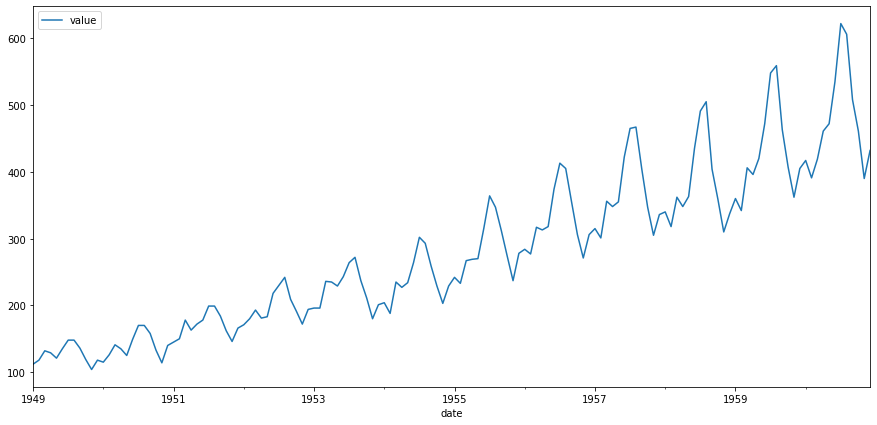

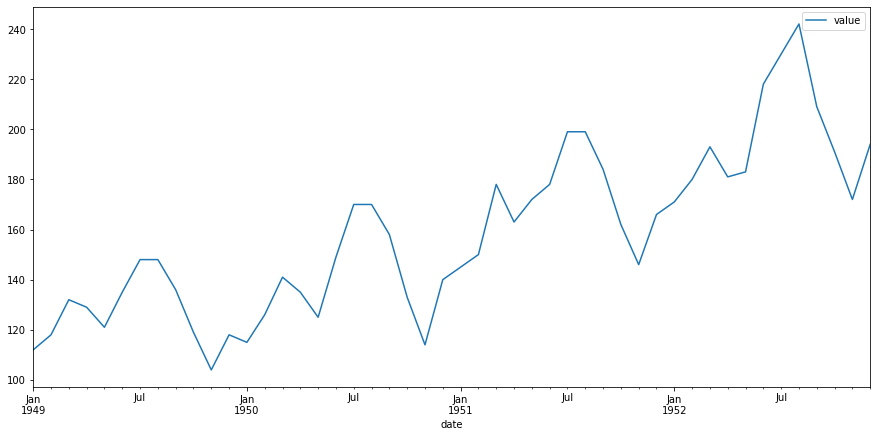

In [49]:
df.plot();
df[:24*2].plot();

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior

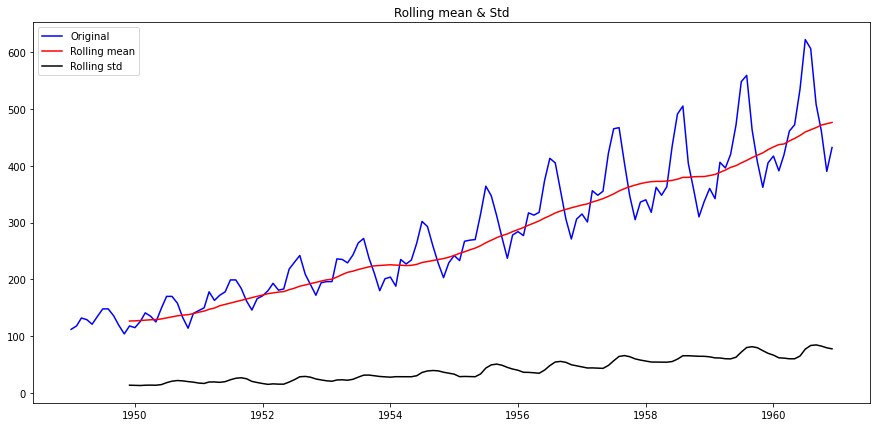

In [50]:
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling mean')
std = plt.plot(rolstd, color='black', label='Rolling std')
plt.legend()
plt.title("Rolling mean & Std");

## 3. Comprueba de manera estadística si la serie es o no stationary.

In [51]:
'''
No es statationary por el test de DF, aunque se aprecia claramente en la gráfica.
'''
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df['value'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060433
p-value: 0.9918802434376409


## 4. Aplica una transformación logarítmica

In [52]:
df['value'] = np.log(df['value'])

## 5. Divide en train y test. Guarda 20 muestras para test.

In [53]:
print(len(df))
train = df['value'][:-20]
test = df['value'][-20:]
print(train.shape)
print(test.shape)

144
(124,)
(20,)


## 6. Crea tu primer modelo ARIMA

In [54]:
from pmdarima.arima import auto_arima, ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [55]:
# Primero pruebo sin seasonality
model = auto_arima(train,
                  max_p=5,
                  max_q=5,
                  max_d=3,
                  stationary=False,
                  warnings=False,
                  errores_action='ignore',
                  trace=True,
                  stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-225.738, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-201.351, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-202.849, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-204.251, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-202.180, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-229.487, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-208.997, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-204.379, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-228.871, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-203.109, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-229.579, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-233.941, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-214.822, Time=0.19 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : 

In [56]:
predictions = model.predict(20)
print('MSE:', mean_squared_error(test.values, predictions))
print('RMSE:', np.sqrt(mean_squared_error(test.values, predictions)))
print('MAE:', mean_absolute_error(test.values, predictions))

MSE: 0.02562603831847829
RMSE: 0.16008134906502472
MAE: 0.1401713972444519


In [57]:
model = auto_arima(train,
                  max_p=5,
                  max_q=5,
                  max_d=3,
                  m=12,
                  stationary=False,
                  warnings=False,
                  errores_action='ignore',
                  trace=True,
                  stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-402.870, Time=1.19 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-290.649, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-399.417, Time=0.79 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-353.179, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-125.472, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-408.701, Time=1.10 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-382.319, Time=0.49 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-406.713, Time=3.04 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-402.096, Time=1.88 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-404.632, Time=4.29 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-409.957, Time=1.71 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-382.629, Time=0.29 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-406.922, Time=1.63 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-407.996, Time=3.76 sec
 ARIMA(1,0,2)(1,1,0

In [58]:
predictions = model.predict(20)
print('MSE:', mean_squared_error(test.values, predictions))
print('RMSE:', np.sqrt(mean_squared_error(test.values, predictions)))
print('MAE:', mean_absolute_error(test.values, predictions))

MSE: 0.0014484523971820997
RMSE: 0.03805853908365506
MAE: 0.02700906511382741


In [59]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  124
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 211.190
Date:                              Tue, 26 Jan 2021   AIC                           -412.379
Time:                                      16:37:44   BIC                           -398.787
Sample:                                           0   HQIC                          -406.864
                                              - 124                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0190      0.010      1.963      0.050    2.63e-05       0.038
ar.L1          0.60

## 7. Representa en una gráfica los datos de test y tus predicciones.

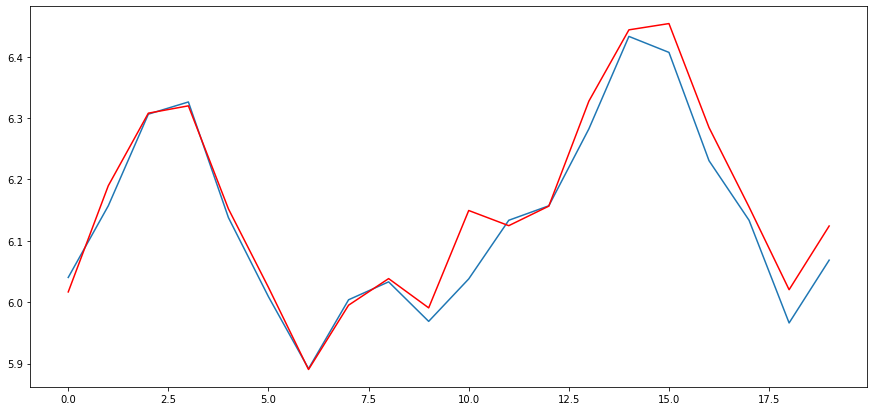

In [60]:
plt.plot(test.values)
plt.plot(predictions, color='red');

In [61]:
predictions2 = pd.Series(predictions)
predictions2.index = test.index

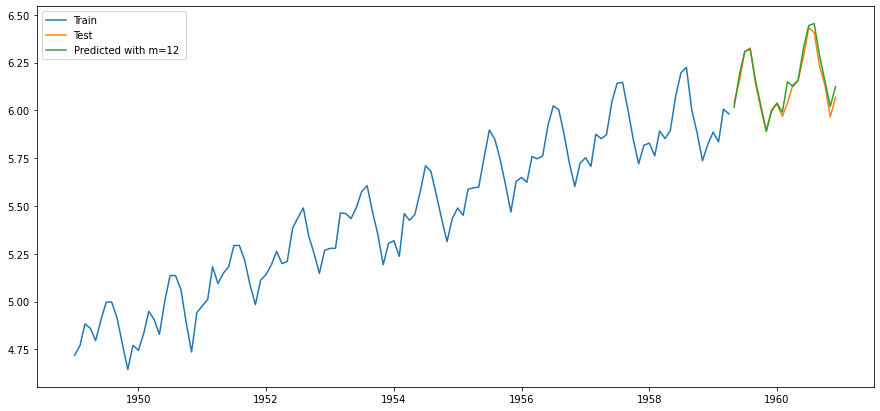

In [62]:

plt.rcParams["figure.figsize"] = [15, 7]
plt.plot(train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(predictions2, label=f'Predicted with m={str(12)} ')
plt.legend(loc='best');

## 8. Prueba otros modelos, a ver qué performance presentan.

In [63]:
for i in range(12, 0, -1):
    df['t-'+str(i)] = df['value'].shift(i)
df.head()

,value,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
date,,,,,,,,,,,,,
1949-01-01,4.718499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,4.770685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.718499
1949-03-01,4.882802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.718499,4.770685
1949-04-01,4.859812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.718499,4.770685,4.882802
1949-05-01,4.795791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.718499,4.770685,4.882802,4.859812


In [64]:
df.dropna(inplace=True)
df.head()

,value,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
date,,,,,,,,,,,,,
1950-01-01,4.744932,4.718499,4.770685,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685
1950-02-01,4.836282,4.770685,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932
1950-03-01,4.948760,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282
1950-04-01,4.905275,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282,4.948760
1950-05-01,4.828314,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282,4.948760,4.905275


In [65]:
len(df)

132

In [66]:
X = df.iloc[:, 1:].values
Y = df.iloc[:, 0].values

X_train = X[:-20]
X_test = X[-20:]

y_train = Y[:-20]
y_test = Y[-20:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112, 12)
(20, 12)
(112,)
(20,)


In [67]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

print('MSE:', mean_squared_error(tree.predict(X_test), y_test))
print('RMSE:', np.sqrt(mean_squared_error(tree.predict(X_test), y_test)))
print('MAE:', mean_absolute_error(tree.predict(X_test), y_test))

MSE: 0.009566197480872193
RMSE: 0.09780693984003483
MAE: 0.07511556776584269


In [68]:
def prediction(model, x_test):
    preds = x_test[0]
    preds_out = []
    for i in range(len(x_test)):
        pred = model.predict([preds])[0]
        preds_out.append(pred)

        preds2 = np.array([preds[1:]])

        preds = np.c_[preds2, np.array([pred])][0]
    return preds_out

In [69]:
'''
Cuidado con los X_test, que se tienen que ir actualizando con cada prediccion
ya que utiliza
'''

'\nCuidado con los X_test, que se tienen que ir actualizando con cada prediccion\nya que utiliza\n'